In [1]:
import lightkurve as lk
from lightkurve_ext import of_sector, of_sectors, of_2min_cadences, of_lcs
import lightkurve_ext as lke
import lightkurve_ext_tess as lket
import tic_plot as tplt
from lightkurve_ext import TransitTimeSpec, TransitTimeSpecList
import lightkurve_ext_pg as lke_pg
import lightkurve_ext_pg_runner as lke_pg_runner

import asyncio_compat

import math
from types import SimpleNamespace
import warnings

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplotlib

import pandas as pd
import astropy as astropy
from astropy import units as u
from astropy.time import Time
from astropy.io import fits

from matplotlib.ticker import (FormatStrFormatter, AutoMinorLocator)

import sys
if "../src" not in sys.path:
    sys.path.append("../src")

import catalog_utils  # from ../src , for accessing various metadata about a TIC

import vetting_utils  # helpers specific for vetting

from importlib import reload # useful during development to reload packages

from IPython.display import display, HTML, Javascript, Markdown
display(HTML("<style>.container { width:99% !important; }</style>"));

display(Javascript("""
// export notebook url to Python for bokeh-based interactive features
IPython.notebook.kernel.execute(`notebook_url = "${window.location.origin}"`);
"""));

%matplotlib inline


<IPython.core.display.Javascript object>

In [2]:
%%javascript
// TODO: revise menu, add keyboard shortcut

// a menu to jump to specific section easily
function addSideNav() {
    let ctr = document.getElementById('nav-ctr');
    if (ctr) { ctr.remove(); }
    const sections = [
        ['#input-tic', 'Enter TIC...'],
        ['#tic-metadata', ['TIC Metadata']],
        ['#lc-all', 'Lightcurves - all'],
        ['#lc-interactive', 'Interactive'],
        ['#lc-zoomed-in', 'Zoomed-in'],
        ['#lc-fold', 'Folded LC'],
        ['#lc-period', "Add. Variability"],
        ['#lc-background-sso', 'Background'],
        ['#tpf_download', 'TPF Download'],
        ['#tpf_zoom_in', 'TPF Zoom in'],
        ['#reports', 'Reports'],
        ['#external_docs', "External Info"]
    ];
    // avoid and arrow functions and string with backslash n 
    // they cause parsing failure with jupyter's display(HTML())
    function toASection(sec) {
      return `              <li><a href="${sec[0]}">${sec[1]}</a></li>`;
    }
    const sectionsHTML = 
        sections.map(toASection).join(`
`);
    document.body.insertAdjacentHTML('beforeend', `
<div id="nav-ctr">
    <style>
        #nav-side {
            position: fixed; right: 2.5vh; top: 2.5em; z-index: 999;
            background-color: #feefc3; border: 1px solid lightgray; border-radius: 10%;
            padding: 0.25em 2ch 0.25em 0.5ch;        
        }
        #nav-side.expand {
            padding: 0.25em 2ch;                
        }
        #nav-side-expand {
            display: none;
        }
        .expand #nav-side-expand {
            display: block;
        }
        #nav-side-ctl-hideshow:before {
            content: "<<";
        }
        .expand #nav-side-ctl-hideshow:before {
            content: ">>";
        }
    </style>
    <div id="nav-side" class="expand"
         style="">
        <div id="nav-side-ctl-hideshow" style="float: right; cursor: pointer;" onclick="this.parentElement.classList.toggle('expand');"></div>
        <div id="nav-side-expand">
            EB Vetting
            <ol>
${sectionsHTML}
            </ol>
        <div id="nav-side-expand">
    </div>
</div>
`);

    // Assign keyboard shortcut to jump to the sections, Alt-1, 2, etc.
    Array.from(document.querySelectorAll('#nav-side-expand li > a'), (a, i) => {
        if (i <= 8) {
          a.accessKey = i + 1;        
        }
    });    
}
addSideNav();

<IPython.core.display.Javascript object>

## Enter TIC, sector, subject
<a name="input-tic">

In [3]:
# lightkurve config
lk_download_dir = "data"

# Run All Above and this cell to start
#
# TIC   : the TIC to be vetted
# sector: the sector that the notebook would use by default as the focus,
#         the lightcurves from all other sectors would be downloaded as well.
#         TPF of the given sector will be downloaded
# subject: an example subject on Planet Hunters TESS for the TIC, usually from the sector above.

# FILL-IN: 
tic, sector, subject = 190693377, 15, 37779492  #  fill-in 281581467, 27, 60853074  

max_num_sectors_to_download = None  #  None to download all sectors. Otherwise set it to a number to cap it, with the supplied sector as the centor of the slice to donwload
to_download_tpf_async = True
to_show_tic_meta = True


def limit_sr_to_download(sr):
    # used to limit data from cycle 1 - 3, but for vetting purpose, we use full data set
    # sr = lk.SearchResult(sr.table[sr.table["sequence_number"] <= 39])
    if max_num_sectors_to_download is None:
            return sr
    return lke.of_sector_n_around(sr, sector, num_additions=max_num_sectors_to_download-1)


try:    
    lcf_coll, sr, sr_unfiltered = lke.download_lightcurves_of_tic_with_priority(tic, 
                                                                                download_filter_func=limit_sr_to_download, download_dir=lk_download_dir,
                                                                                author_priority=["SPOC", "TESS-SPOC", "QLP"],
                                                                               )
    lcf_coll_original = lcf_coll  # retain a reference to the downloaded collection in case I modify it later
finally:
    tplt.beep()  # a beep to remind the users that the data has been downloaded


# Start downloading TPF asycnhronously while the user inspects the lightcurve
# Users can jump to "TPF Download" section to access the result
tpf_task = None
if to_download_tpf_async:
    tpf_task = lke.create_download_tpf_task(f"TIC{tic}", sector=sector, exptime="short", author='SPOC', mission="TESS", download_dir=lk_download_dir)


metadata_html_task = None  # load TCEs asycnhronously  while the user inspects the lightcurve
if to_show_tic_meta:
    metadata_html_task = asyncio_compat.create_background_task(tplt.get_tic_meta_in_html, of_sector(lcf_coll, sector), a_subject_id=subject, download_dir=lk_download_dir)


lc = of_sector(lcf_coll, sector)
lket.display_crowdsap(lc)

4 rows filtered


#,mission,year,author,exptime,target_name,distance,proposal_id
,,,,s,,arcsec,
0,TESS Sector 15,2019,SPOC,120,190693377,0.0,N/A
1,TESS Sector 16,2019,SPOC,120,190693377,0.0,N/A


TIC 190693377 	#sectors: 2 ; 15 - 16
   sector 16: 	camera = 1 ; ccd = 2


In [ ]:
# for triage MAST query issues
# _sr  = lk.search_lightcurve(f"TIC{tic}", mission="TESS")
#
# when needed, run this cell to download all sectors from primary mission or specific sectors
# lcf_coll = lk.SearchResult(sr.table[np.in1d(sr.table["sequence_number"], [1, 11, 12, 13])]).download_all(download_dir=lk_download_dir)
# tplt.beep()
# lcf_coll

## TIC Metadata
<a name="tic-metadata">

In [4]:
# reload(tplt)
# metadata_html_task = asyncio_compat.create_background_task(tplt.get_tic_meta_in_html, of_sector(lcf_coll, sector), a_subject_id=subject, download_dir="data")
display(HTML(await metadata_html_task))

## <span style="background-color: red">False Positive</span>

Clear NEB from TCE centroid offset diagnostics. See External Info section.

## Variabiility from other catalogs
<a name="meta_other_catalogs"></a>

In [ ]:
# Used for display here, but also for later, e.g., in reports
all_meta = catalog_utils.get_all_meta_of_tic(tic)

vetting_utils.display_all_meta_highlights(all_meta)

## Lightcurves - all sectors
<a name="lc-all">

In [ ]:
obs_span, num_days = lke.get_obs_date_range(lcf_coll)
print(f"Obs span: {obs_span}  ; num. of days: {num_days}")


# ---

lc = lke.stitch(
    lcf_coll,
    corrector_func=lambda lc: (
        lc
#         .select_flux("sap_flux")
#         .remove_outliers(sigma=7)
        .normalize(unit="percent")
    ),
    ignore_incompatible_column_warning=True,
).normalize(unit="percent")

print(f"Sectors {lke.abbrev_sector_list(lc.meta['SECTORS'])}:")
axs = tplt.plot_skip_data_gap(lc, figsize=(30,6), s=2, alpha=0.5);
axs[0].get_figure().suptitle(f"{lc.label}, sectors {lke.abbrev_sector_list(lc.meta['SECTORS'])}", fontsize=20);
# [ax.set_ylim(99.8, None) for ax in axs];


# Zoom in to the first and the last known sectors

figsize=(12, 6)
if len(lcf_coll) >= 2:
    lcf_coll_first_last = lk.LightCurveCollection([lcf_coll[0], lcf_coll[-1], ])
else:
    lcf_coll_first_last = lk.LightCurveCollection([lcf_coll[0]])

axs = tplt.plot_all(
    lcf_coll_first_last,
    moving_avg_window='20min',
    ax_fn=lambda: tplt.lk_ax(figsize=figsize),
    use_relative_time=False,
    mark_quality_issues=False,
    mark_momentum_dumps=True,
    set_title=False,
)

# as a sanity check, in case PDCSAP_FLUX has some anomaly (e.g., remvoing a good dip)
ax_flux_cmp = tplt.plot_flux_sap_flux_comparison(of_sector(lcf_coll, sector), ax=plt.figure(figsize=figsize).gca(),
                                                 offset=None)


### Manual exclude problematic cadences, if any

In [ ]:
to_mask_out_cadences = False

if to_mask_out_cadences:
    # a new collection that I'd modify
    lcf_coll = lk.LightCurveCollection(lcf_coll_original.data)
    # custom codes to mask out problematic cadences
    #
    # the flux in sector 9 QLP lc at the beginning of an orbit does not appear to be reliable
    # it seems background is not subtracted sufficiently
    idx =  # FILL IN
    lc = lcf_coll[idx]  
    lc = lke.exclude_range(lc, )   # FILL IN
    lcf_coll[idx] = lc

    # plot all lightcurves again for visual validation
    axs = tplt.plot_skip_data_gap(
        lke.stitch(lcf_coll, corrector_func=tplt.normalize_percent, ignore_incompatible_column_warning=True),
        figsize=(30,6), s=2, alpha=0.5
        );


## Identify initial period with BLS

In [ ]:
run_bls = False

if run_bls:
    lc = lke.stitch(
        lcf_coll, 
        corrector_func=lambda lc: lc.normalize(unit="percent"),
        ignore_incompatible_column_warning=True,
    )
    
    result = lke_pg_runner.run_bls(lc, pg_kwargs=dict(
#         minimum_period=1, maximum_period=20,
    ))
#     lc.normalize().interact_bls(notebook_url=notebook_url)

## Magnitude Range / Amplitude

In [ ]:
# magnitude range is derived in this cell by converting raw TESS flux (15000 e/s for magniutde 10)
# leave it here for reference, we don't use it for now

# We DO NOT do per-sector normalization so as to expose long term variation
lc = lke.stitch(
    lke.select(lcf_coll, lambda lc: lc.author in ["SPOC", "TESS-SPOC"]),  # use LCs with flux in electron/S with consistent processing
    corrector_func=lambda lc: (
        lc
        .remove_nans()
#         .select_flux("sap_flux")
    ))
# .normalize(unit="percent")

print(f"Sectors {lke.abbrev_sector_list(lc.meta['SECTORS'])}:")
axs = tplt.plot_skip_data_gap(lc, figsize=(30,6), s=2, alpha=0.5);
axs[0].get_figure().suptitle(f"{lc.label}, sectors {lke.abbrev_sector_list(lc.meta['SECTORS'])}", fontsize=20);
# [ax.set_ylim(99.8, None) for ax in axs];
print("Max/Min:", lket.tess_flux_to_mag(lc.flux.max()), lket.tess_flux_to_mag(lc.flux.min()))



In [ ]:
# Derive magniude range from normalized lightcurve with mean TESS mag from TIC as the base

lc = lke.stitch(
    lke.select(lcf_coll, lambda lc: lc.author in ["SPOC", "TESS-SPOC"]),  # use LCs with flux in electron/S with consistent processing
    corrector_func=lambda lc: (
        lc
        .remove_nans()
#         .select_flux("sap_flux")
    )).normalize(unit="percent")

print(f"Sectors {lke.abbrev_sector_list(lc.meta['SECTORS'])}:")
axs = tplt.plot_skip_data_gap(lc, figsize=(30,6), s=2, alpha=0.5);
axs[0].get_figure().suptitle(f"{lc.label}, sectors {lke.abbrev_sector_list(lc.meta['SECTORS'])}", fontsize=20);
# [ax.set_ylim(99.8, None) for ax in axs];


flux_range_pct = np.asarray([lc.flux.max(), lc.flux.min()])
tic_tmag = lc.meta.get("TESSMAG")
flux_range_mag = lke.normalized_flux_val_to_mag(flux_range_pct, base_mag=tic_tmag)

print("Max/Min (normalized):", flux_range_pct[0], flux_range_pct[1])
print("Max/Min (magnitude) :", flux_range_mag[0], flux_range_mag[1])

## Lightcurve - interactive
<a name="lc-interactive">

In [ ]:
# interactively view a lightcurve 
lcf = of_sector(lcf_coll, sector)


lket.display_crowdsap(lcf)
display(HTML(f"TSTART: {lcf.meta.get('TSTART')}"))  # To aid relative time conversion


# make zoom in to a specific dip eaiser
tplt.plot_transit_interactive(lcf, figsize=(30, 10)
#                               ,flux_col='sap_flux'
                             );

## Lightcurve - zoomed in
<a name="lc-zoomed-in"></a>

- Eclipse specification is defined here in `transit_specs`

In [ ]:
# Plots, zoomed-in around selected dips / transits

transit_specs = TransitTimeSpecList(
    dict(epoch=2037.2852, duration_hr=4.7531, period=3.990926, label="deep, s0001-s0039:TCE1",  # period is 2X of TCE period 1.995463 * 2
         sector=27, steps_to_show=[0, 5],
        ),
    dict(epoch=2039.280663, duration_hr=4.7531, period=3.990926, label="shallow, s0001-s0039:TCE1",  # epoch is 2037.2852 + 1.995463, deep's epoch + 1/2 period
         sector=27, steps_to_show=[0, 4],
        ),    
    defaults=dict(surround_time=1.0)
)


def custom_lc_tweak(lc):
    res = lc
    # res = res.remove_outliers(sigma=7)
    # res = res.bin(time_bin_size=20 * u.min)
    return res

figsize = (8, 4) # (16, 4)
axs = tplt.plot_transits(    
                         lcf_coll # [of_sectors(lcf_coll, 27)[1], of_sectors(lcf_coll, 28)[1]]
                         , transit_specs
#                          , flux_col = "sap_flux"
                         , ax_fn=lambda: plt.figure(figsize=figsize).gca()    
                         , t0mark_ymax=0.05
#                          , lc_tweak_fn=lambda lc: lc.remove_outliers(sigma=7)
                         , lc_tweak_fn=custom_lc_tweak
                         , moving_avg_window='20min' # None # '30min' # '10min' # None, '20min' #  '30min'
#                          , set_title=False
                         , show_r_obj_estimate=False
                         , title_fontsize=12
                        )
# axs[0].set_ylim(None, 100.15)
print('Transits, zoomed-in');
display(transit_specs.to_table());

## Lightcurves - eclipses marked
<a name="lc-transits">

In [ ]:
red_marks = dict(linestyle='--', color="red")
blue_marks = dict(linestyle='--', color="blue")
yellow_marks = dict(linestyle='--', color="yellow", ymin=0.1, ymax=0.3, linewidth=2)  # , ymax=0.5
orange_marks = dict(linestyle=':', color="orange", ymin=0.1, ymax=0.3)  # , ymax=0.8
green_marks = dict(linestyle='--', color="green", ymax=0.4)  # , ymax=0.8
purple_marks = dict(linestyle=':', color="purple", ymax=0.4)  # , ymax=0.5

# customize these parameters if needed
lcf_coll_to_use = lcf_coll
tt_specs = transit_specs


axvline_kwargs_specs = [
    red_marks,
    blue_marks
]
skip_no_transit_plot = True

# Now do the marking
axs, tt_lists = [], []
for lc_to_use in lcf_coll_to_use :
    with warnings.catch_warnings():
        # avoid warnings about repeated normalization
        warnings.filterwarnings("ignore", category=lk.LightkurveWarning, message=".*in relative units.*")
#         lc_to_use = tplt._to_lc_with_flux(lc_to_use, "sap_flux")
        lc_to_use = lc_to_use.normalize(unit="percent")  # .remove_outliers(sigma=7)
    ax = plt.figure(figsize=(25, 5)).gca()
    ax1, tt_list = tplt.mark_transit_times(lc_to_use, tt_specs,
                                           axvline_kwargs_specs=axvline_kwargs_specs,
                                           ax=ax,
                                           skip_no_transit_plot=skip_no_transit_plot,
#                                            lc_plot_func_name="plot",
                                          )
    if ax1 is not None:
        axs.append(ax1), tt_lists.append(tt_list)
    else:
        plt.close(ax.figure)

print(tt_specs);
print(tt_lists);
# axs[-1].set_ylim(None, 100.5)

### Plot marked dips, zoomed in

In [ ]:
surround_time = 0.5
specs_idx = 0  # deep eclipses

t0, period, duration_hr, label = tt_specs[specs_idx]["epoch"], tt_specs[specs_idx]["period"], tt_specs[specs_idx]["duration_hr"], tt_specs[specs_idx]["label"]

figsize = (8, 4)

def tweak_axs(axs):
#     [ax.set_ylim(axs[-1].get_ylim()) for ax in axs];
#     [ax.set_ylim(99.7, 100.2) for ax in axs];
    return axs;

print("period: ", period, ", t0: ", t0)

axs = []
# check how well the predicted dips fit with observation, using the first and the last sector in the collection
for lc in of_sectors(lcf_coll_to_use[:], lcf_coll_to_use[0].sector, lcf_coll_to_use[-1].sector):
    lc = lke.select_flux(lc, ["flux"])  # ["kspsap_flux", "flux"] #  "sap_flux"
    lc_sap = lc.select_flux("sap_flux") #  use SAP_FLUX to calc transit time to get dips only in SAP_FLUX
    transit_times = lke.get_transit_times_in_lc(lc_sap, t0, period, return_string=False,
#                                                 break_tolerance=1e7,  # also mark data gap, by setting large break_tolerance
                                               )
    for tt in transit_times[:3]:  # limit to 3 per sector for clarity
        with plt.style.context(lk.MPLSTYLE):
            if True:   # for FLUX
                ax = plt.figure(figsize=figsize).gca()
                tplt.plot_transit(lc, ax, tt, duration_hr / 24, surround_time,
                                  moving_avg_window="20min", 
                                  title_fontsize=10,                              
                                  show_r_obj_estimate=True,        
                                  legend_kwargs=dict(fontsize=7, loc="upper right")
                                 )
                axs.append(ax)
        
tweak_axs(axs);    

## Lightcurves - folded
<a name="lc-fold">

In [ ]:
# Fold lightcurves

# use all LCs  to see better ensure the period is good
lc = lke.stitch(lcf_coll, corrector_func=tplt.normalize_percent, ignore_incompatible_column_warning=True)

t0 = transit_specs[0]["epoch"]
period = transit_specs[0]["period"]

figsize = (12, 6)
time_bin_size = None  # 10 * u.minute 

if time_bin_size is not None:
    lc_b = lke.bin_flux(time_bin_size=time_bin_size)
else:
    lc_b = lc


ax1, lc_f1 = tplt.fold_and_plot(lc_b, period, t0, figsize=figsize)
ax2, lc_f2 = tplt.fold_2x_periods_and_plot(lc_b, period, t0, figsize=figsize)

# used by subsequent cells
obs_actual_days = len(set([int(v) for v in lc_f1.time_original.value]))
obs_actual_cycles = len(set(lc_f1.cycle))
print(f"# days: {obs_actual_days} ; # cycles: {obs_actual_cycles}")

In [ ]:
to_animate_folded_lc = False

if to_animate_folded_lc:
    ax = tplt.lk_ax(figsize=(10, 5))
    with plt.style.context(lk.MPLSTYLE):  # needed to main lightkurve style in animation
        lc_to_use = lc_f1
        tplt.animate_folded_lightcurve(lc_to_use, ax=ax, interval=750, num_frames=240, plot_kwargs=dict(s=9));
    lc_to_use.meta.get("TARGETID"), len(np.unique(tplt.calc_cycles(lc_to_use)))

## Eclipse Depth from observation
- use folded, detrended, normalized lightcurve
- calculate flux at minimum as the median flux of a 10 minute window of the minimum (possibly many data points due to folding)
- eclipse depth is `1 - flux_at_minimum`, assuming regular (out of eclipse) flux is 100%

In [ ]:
# Detrend then fold,
# - eclipses masked out during detrend to preserve them

# use 2 min cadence lightcurves only to make flattening easier (with consistent cadence)
lc = of_lcs(lcf_coll, lambda lc: lc.author == "SPOC").stitch(corrector_func=tplt.normalize_percent)

window_length_days = 2 / 24
lc_flattened = lc.flatten(window_length=lke.to_window_length_for_2min_cadence(window_length_days),
                          mask=lc.create_transit_mask(transit_time=transit_specs.epoch, period=transit_specs.period, duration=transit_specs.duration)
                         ).normalize(unit="percent")

In [ ]:
# visualize the detrended lightcurve 

figsize = (20, 4)
figsize_z = (8, 4)

axs = tplt.plot_skip_data_gap(lc, figsize=figsize, s=2, alpha=0.5);
axs[0].get_figure().suptitle(f'{lc.label}')

axs = tplt.plot_skip_data_gap(lc_flattened, figsize=figsize, s=2, alpha=0.5);
axs[0].get_figure().suptitle(f'{lc_flattened.label}, flattened with a window {window_length_days} days')

zoom_window = 5

zoom_b, zoom_e = np.ceil(lc_flattened.time.min().value) + 1, np.ceil(lc_flattened.time.min().value) + 1 + zoom_window
lc.truncate(zoom_b, zoom_e).scatter(ax=tplt.lk_ax(figsize=figsize_z));
ax = lc_flattened.truncate(zoom_b, zoom_e).scatter(ax=tplt.lk_ax(figsize=figsize_z), label=f'{lc.label}, flattened');

zoom_b, zoom_e = np.ceil(lc_flattened.time.max().value) - 1 - zoom_window, np.ceil(lc_flattened.time.max().value) - 1
lc.truncate(zoom_b, zoom_e).scatter(ax=tplt.lk_ax(figsize=figsize_z));
ax = lc_flattened.truncate(zoom_b, zoom_e).scatter(ax=tplt.lk_ax(figsize=figsize_z), label=f'{lc.label}, flattened');

### Deep Eclipse depth

In [ ]:
t0 = transit_specs[0]["epoch"]
period = transit_specs[0]["period"]
duration = transit_specs[0]["duration_hr"] / 24

lc_ff_deep = lc_flattened.fold(epoch_time=t0, period=period)

flux_min_deep, flux_min_deep_sample_size = lke.calc_flux_at_minimum(lc_ff_deep)
depth_deep = 1 - flux_min_deep
print(f"Deep eclipse depth: {100*depth_deep:.3f}% ; num. data points: {flux_min_deep_sample_size}")

ax, ax_z = tplt.plot_n_annotate_folded(lc_ff_deep, annotate=False, also_plot_zoom_transit=True, duration=duration)

### Shallow Eclipse Depth

In [ ]:
t0 = transit_specs[1]["epoch"]
period = transit_specs[1]["period"]
duration = transit_specs[1]["duration_hr"] / 24

lc_ff_shallow = lc_flattened.fold(epoch_time=t0, period=period)

flux_min_shallow, flux_min_shallow_sample_size = lke.calc_flux_at_minimum(lc_ff_shallow)
depth_shallow = 1 - flux_min_shallow
print(f"Shallow eclipse depth: {100*depth_shallow:.3f}% ; num. data points: {flux_min_shallow_sample_size}")

ax, ax_z = tplt.plot_n_annotate_folded(lc_ff_shallow, annotate=False, also_plot_zoom_transit=True, duration=duration)

## Identify additional variability
<a name="lc-period">

### Mask out eclipses
to visualize the remaining fluctuations

In [ ]:
# use LCs with all cadences
lc = lke.stitch(lcf_coll, corrector_func=lambda lc: lc.remove_nans(), ignore_incompatible_column_warning=True)

## use LCs with flux in electron/s only, to calculate FAP
# lc = lke.stitch(lke.select(lcf_coll, lambda lc: lc.author in ["SPOC", "TESS-SPOC"]), corrector_func=lambda lc: lc.remove_nans(), ignore_incompatible_column_warning=True)

t_mask = lc.create_transit_mask(transit_time=transit_specs.epoch, period=transit_specs.period, duration=transit_specs.duration)
lc_masked = lc[~t_mask]

with plt.style.context(lk.MPLSTYLE):
    figsize = (20, 4)
    axs = tplt.plot_skip_data_gap(lc_masked, figsize=figsize, s=2, alpha=0.5);
    axs[0].get_figure().suptitle(f'{lc_masked.label}')

### Lomb Scargle Periodogram

In [ ]:
pg = (
    lc_masked
    .to_periodogram(method="lombscargle"
#                        , minimum_period=.01, maximum_period=25,
                      )
     )
pg.show_properties();

In [ ]:
lke_pg.plot_pg_n_mark_max(pg, max_period_factor=10);

ax = pg.plot(view="period")  # period view, zoom in around peak
ax.set_xlim(pg.period_at_max_power.value / 3 , pg.period_at_max_power.value * 5/3);

ax = pg.plot(view="frequency");  # frequency view
ax.set_xlim(pg.frequency_at_max_power.value / 100 , pg.frequency_at_max_power.value * 5);

if not lc.meta.get("NORMALIZED") and pg.nterms == 1:
    # calc FAP. Somehow it does not work with normalized flux (always return 1.0 for normalized flux)
    pg_fap = pg._LS_object.false_alarm_probability(pg.max_power, method="baluev")  # the FAP is often useless if the lc is normalized
    print("False Alarm Probability:", pg_fap)

In [ ]:
axs = lke_pg.plot_lc_with_model(lc_masked.normalize(), pg);

Animated folded lightcurve 

If the target has additional rotational variability,
- the period holds across sectors
- but the pattern within a period evolves over time. 

In [ ]:
lc_add_var_f = lc_masked.normalize(unit="percent").fold(epoch_time=lc_masked.time.min(), period=pg.period_at_max_power)
ax = lc_add_var_f.scatter(alpha=1.0, s=0.1);
ax.set_title("Folded with Periodogram period, eclipses masked");

In [ ]:
# animate the folded lightcurve (with periodogram period)
to_animate_folded_lc = True

if to_animate_folded_lc:
    ax = tplt.lk_ax(figsize=(8, 4))
    with plt.style.context(lk.MPLSTYLE):  # needed to main lightkurve style in animation
        lc_to_use = lc_add_var_f
        tplt.animate_folded_lightcurve(lc_to_use, ax=ax, interval=750, num_frames=240, plot_kwargs=dict(s=9));
    lc_to_use.meta.get("TARGETID"), len(np.unique(tplt.calc_cycles(lc_to_use)))

In [ ]:
lc_add_var_f_e = lc_masked.normalize(unit="percent").fold(epoch_time=lc_masked.time.min(), period=transit_specs[0]["period"])
ax = lc_add_var_f_e.scatter(alpha=1.0, s=0.1);
ax.set_title("Folded with Eclipse period, eclipses masked");

In [ ]:
# animate the folded lightcurve (with eclipse period)
to_animate_folded_lc = False

if to_animate_folded_lc:
    ax = tplt.lk_ax(figsize=(8, 4))
    with plt.style.context(lk.MPLSTYLE):  # needed to main lightkurve style in animation
        lc_to_use = lc_add_var_f_e
        tplt.animate_folded_lightcurve(lc_to_use, ax=ax, interval=750, num_frames=240, plot_kwargs=dict(s=9));    

## Contamination Check
<a name="contamination"></a>

### Lightcurve - background
<a name="lc-background-sso">

In [ ]:
specs_idx, step_idx = 0, 0

lc = of_sector(lcf_coll,  transit_specs[specs_idx]["sector"])
lc = lc.normalize(unit='percent')

# Check the background flux for the duration in question
t0 = transit_specs[specs_idx]["epoch"]
period = transit_specs[specs_idx]["period"]
search_period = transit_specs[specs_idx]["duration_hr"] * 1.3 / 24
plot_period = search_period * 1.5 

steps_to_show = transit_specs[specs_idx]["steps_to_show"]
t0 = t0 + period *  steps_to_show[step_idx]

search_start, search_end = t0 - search_period /2, t0 + search_period /2
plot_start, plot_end = t0 - plot_period /2, t0 + plot_period /2

plot_binned = False
plot_sap_flux = False

fig, axs = plt.subplots(3 if plot_binned else 2, 1, sharex=True, figsize=(12, 10.5 if plot_binned else 7))
fig.subplots_adjust(hspace=0)

time_mask = (lc.time.value >= plot_start) & (lc.time.value <= plot_end)
if plot_binned:
    lc_b = lke.bin_flux(lc, time_bin_size = 30 * u.minute)  # bin it to speed up SSO search
    lc_b[(lc_b.time.value >= plot_start) & (lc_b.time.value <= plot_end)].scatter(ax=axs[0], label=lc.label + ' binned')

if plot_sap_flux:
    lc_sap[time_mask].scatter(column='sap_flux', ax=axs[-2], c='orange', label=lc.label + 'SAP')
else:
    lc[time_mask].scatter(ax=axs[-2], label=lc.label + ' PDCSAP')
    
lc_bkg = lke.get_bkg_lightcurve(lc)
lc_bkg[time_mask].scatter(ax=axs[-1], color='gray')

if True and search_start is not None:
    for ax in axs:
        ax.axvline(search_start, linestyle='--', c='r')
        ax.axvline(search_end, linestyle='--', c='r')

print('t0=', t0);

### TPF Download
<a name="tpf_download">

In [ ]:
# Google colab user: this cell will fail with SyntaxError in await
# use the next cell instead.

global tpf_task  # need to define it as global, otherwise UnboundLocalError would occur
if tpf_task is None:
    tpf_task = lke.create_download_tpf_task(f"TIC{tic}", sector=sector, exptime="short", author='SPOC', mission="TESS", download_dir="data")
# else the download has been previoulsy initiated (in "Enter TIC" section, no need to do it),
#      no need to do it again

try:
    tpf_coll, sr_tpf = await tpf_task
    display(sr_tpf)
    
    if tpf_coll is not None and len(tpf_coll) > 0: 
        tpf_original =  tpf_coll[0]
        # data around a momentum dump is often very noisy, exclude them to avoid skewing subsequent plots
        tpf = lket.MomentumDumpsAccessor.exclude_around(tpf_original, window_before=15/60/24, window_after=15/60/24)

        print(tpf, " , sector", tpf.sector)
        print("     time:", tpf.time.min() , "-", tpf.time.max())
        print("cadenceno:", tpf.cadenceno.min() , "-", tpf.cadenceno.max())

        lc = tpf.to_lightcurve().remove_outliers(sigma=8)
        ax = lc.scatter();
        tplt.plot_momentum_dumps(lc, ax)
finally: 
    tplt.beep()
    tpf_task = None  # once task result is consumed, reset it so that one can run it again in the next run

### TPF Zoom in, deep eclipse
<a name="tpf_zoom_in">

In [ ]:
ylim_func = lambda lc: (np.nanmin(lc.flux), np.nanmax(lc.flux))
# ylim_func = lambda lc: (np.nanpercentile(lc.flux, 0.1), np.nanpercentile(lc.flux, 99.9))

specs_idx, step_idx = 0, 0
t0 = transit_specs[specs_idx]["epoch"]
duration = transit_specs[specs_idx]["duration_hr"] / 24
period = transit_specs[specs_idx]["period"]
steps_to_show = transit_specs[specs_idx]["steps_to_show"]
t0 = t0 + period * steps_to_show[step_idx]
surround_time = 2.0

plot_start, plot_end = t0 - duration / 2 - surround_time / 2,  t0 + duration /2 + surround_time / 2


print('t0 =', t0);

# zoomed in to the time around the dip 
tpf_trunc = tpf[(tpf.time.value >= plot_start) & (tpf.time.value <= plot_end)]  # for Lightkurve 2 API

# zoom to arbitrary date range
# tpf_trunc = tpf[(tpf.time >= tpf.time.min() + 3) & (tpf.time <= tpf.time.min() + 12)]

if len(tpf_trunc) < 1:
    display(HTML("""<font style="background-color: red;">WARNGING:</font> the truncated TPF is zero length. Sunsequent operations would fail."""))


if (tpf_trunc.time.max() - tpf_trunc.time.min()) > 3 * u.day:
    display(HTML(('<span style="background-color: yellow">Note:</span> The TPF spans over a long time. Consider to zoom in. Duration: '
                  f'{(tpf_trunc.time.max() -tpf_trunc.time.min()).to(u.day)}')))

if 'google.colab' in str(get_ipython()):
    tpf_trunc.to_lightcurve().scatter();
else: 
    tpf_trunc.interact(ylim_func=ylim_func,
#                        aperture_mask=tpf.background_mask
                       transform_func=tplt.normalize_percent,
                       notebook_url=notebook_url,
                      );

In [ ]:
tpf_mag = tpf_trunc.meta.get("TESSMAG")
print('Target magnitude: ', tpf_mag)
magnitude_limit = tpf_mag + 8 if tpf_mag is not None else 18

tplt.show_tpf_orientation(tpf)
tplt.interact_sky(tpf_trunc, aperture_mask="pipeline", magnitude_limit = magnitude_limit, notebook_url=notebook_url,);
tplt.show_nearby_tic_summary_form();

In [ ]:
pixel_size_inches, markersize = 1.0, 0.8
fig = plt.figure(figsize=(tpf.flux[0].shape[1] * pixel_size_inches, tpf.flux[0].shape[0] * pixel_size_inches))
ax = tpf_trunc.plot_pixels(ax=fig.gca(), aperture_mask=tpf_trunc.pipeline_mask, show_flux=True, markersize=markersize);
tplt.beep();

### TPF Zoom In, shallow eclipses

In [ ]:
ylim_func = lambda lc: (np.nanmin(lc.flux), np.nanmax(lc.flux))
# ylim_func = lambda lc: (np.nanpercentile(lc.flux, 0.1), np.nanpercentile(lc.flux, 99.9))

specs_idx, step_idx = 1, 0
t0 = transit_specs[specs_idx]["epoch"]
duration = transit_specs[specs_idx]["duration_hr"] / 24
period = transit_specs[specs_idx]["period"]
steps_to_show = transit_specs[specs_idx]["steps_to_show"]
t0 = t0 + period *  steps_to_show[step_idx]
surround_time = 2.0

plot_start, plot_end = t0 - duration / 2 - surround_time / 2,  t0 + duration /2 + surround_time / 2


print('t0 =', t0);

# zommed in to the time around the dip 
tpf_trunc = tpf[(tpf.time.value >= plot_start) & (tpf.time.value <= plot_end)]  # for Lightkurve 2 API

# zoom to arbitrary date range
# tpf_trunc = tpf[(tpf.time >= tpf.time.min() + 3) & (tpf.time <= tpf.time.min() + 12)]

if len(tpf_trunc) < 1:
    display(HTML("""<font style="background-color: red;">WARNGING:</font> the truncated TPF is zero length. Sunsequent operations would fail."""))


if (tpf_trunc.time.max() - tpf_trunc.time.min()) > 3 * u.day:
    display(HTML(('<span style="background-color: yellow">Note:</span> The TPF spans over a long time. Consider to zoom in. Duration: '
                  f'{(tpf_trunc.time.max() -tpf_trunc.time.min()).to(u.day)}')))

if 'google.colab' in str(get_ipython()):
    tpf_trunc.to_lightcurve().scatter();
else: 
    tpf_trunc.interact(ylim_func=ylim_func,
#                        aperture_mask=tpf.background_mask
                       transform_func=tplt.normalize_percent,
                       notebook_url=notebook_url,
                      );

In [ ]:
fig = plt.figure(figsize=(tpf.flux[0].shape[1] * pixel_size_inches, tpf.flux[0].shape[0] * pixel_size_inches))
ax = tpf_trunc.plot_pixels(ax=fig.gca(), aperture_mask=tpf_trunc.pipeline_mask, show_flux=True, markersize=markersize);
tplt.beep();

## Reports
<a name="reports"></a>

In [ ]:
# Common elements for reports

def get_mag_range_mag_text():
    return f"Mag. range: {flux_range_mag[0]:.2f} - {flux_range_mag[1]:.2f} TESS"


# Fill in for this target
variable_type = "EA/RS"
remarks = f"{get_mag_range_mag_text()} . Rotational period: {lc_add_var_f.meta['PERIOD']:.5f} . Some flares."

# Common helpers, no need to modify
def report_to_df(report):
    df = pd.DataFrame()
    df["Field"] = report.keys()
    df["Value"] = report.values()
    return df

### EB Report 
<a name="eb_report"></a>

In [ ]:
obs_span_cycles = obs_span / transit_specs[0]["period"]
sectors_all = ",".join([str(s) for s in sr.table["sequence_number"]])
sectors_short_cadence = ",".join([str(s) for s in sr[sr.author == "SPOC"].table["sequence_number"]])  # it could include fast cadence in theory, but not relevant for our usage here.

eb_report = dict(
    tic_id=tic,
    variable_type=variable_type,
    period=transit_specs[0]["period"],
    epoch_deep=transit_specs[0]["epoch"],
    duration_hr_deep=transit_specs[0]["duration_hr"],
    depth_deep=depth_deep,
    epoch_shallow=transit_specs[1]["epoch"],
    duration_hr_shallow=transit_specs[1]["duration_hr"],
    depth_shallow=depth_shallow,
    observation_span_days=obs_span,
    observation_span_cycles=obs_span_cycles,
    observation_actual_days=obs_actual_days,
    observation_actual_cycles=obs_actual_cycles,
    sectors=sectors_all,  # used to determine period, epoch, duration 
    sectors_short_cadence=sectors_short_cadence,  # used to deteremine depth
    remarks=remarks,  
)

with pd.option_context('display.max_colwidth', None):
    display(report_to_df(eb_report))

### VSX Report
<a name="vsx_report"></a>

In [ ]:
if len(all_meta.gaia) > 0:
    target_ra = all_meta.gaia['RAdeg'].iloc[0]
    target_dec = all_meta.gaia['DEdeg'].iloc[0]
    target_position = f"{target_ra}, {target_dec}"
    target_position_src = "Gaia DR3"
else:
    print("No Gaia DR3 position available. Use custom one")
    target_position = "to fill in"
    target_position_src = "to fill in"

    
# heuristics to determine primary name for VSX
if len(all_meta.vsx) > 0:
    print("INFO: case updating an existing VSX entry. Use existing primary name")
    primary_name = all_meta.vsx["Name"].iloc[0]
elif len(all_meta.simbad) > 0:
    primary_name = all_meta.simbad["MAIN_ID"].iloc[0]
elif len(all_meta.asas_sn) > 0:
    primary_name = all_meta.asas_sn["ASASSN-V"].iloc[0]
else:
    primary_name = "to fill in"
    

other_names = "[to fill in]"


# include Gaia DR3 ID if it is in Gaia DR3 Variable
extra_names_gaia_dr3 = ""
if len(all_meta.gaia) > 0 and not pd.isna(all_meta.gaia["Class"].iloc[0]):
    extra_names_gaia_dr3 = f",Gaia DR3 {all_meta.gaia['Source'].iloc[0]}"


def summarize_shallow_eclipse():
    return (f"Min II epoch: {lket.btjd_to_hjd_utc(transit_specs[1]['epoch'], target_position):.4f}"
            f", duration: {transit_specs[1]['duration_hr'] * 24 / transit_specs[1]['period']:.2f}%"
            f", amplitude: {lke.ratio_to_mag(depth_shallow):.3f} .")

BIBS = vetting_utils.BIBS

vsx_report = dict(
    Position=target_position,
    Primary_Name=primary_name,
    Other_Names=f"TIC {tic}{other_names}{extra_names_gaia_dr3}",  # addition to existing ones for updates
    Variable_Type=variable_type,
    Spectral_Type="[to fill in]",  # based on to fill in
    Spectral_Type_Uncertain=True,
    Maximum_Magnitude=, # to fill in, either mean mag, or max mag of the range
    Maximum_Magnitude_band="V",
    Minimum_Magnitude=f"{lke.ratio_to_mag(depth_deep):.3f}",
    Minimum_Magnitude_band="TESS",
    Minimum_Is_Amplitude=True,
    Period=f"{transit_specs[0]['period']:.5f}",
    Epoch=f"{lket.btjd_to_hjd_utc(transit_specs[0]['epoch'], target_position):.4f}",
    Rise_Duration_Pct=f"{transit_specs[0]['duration_hr'] * 24 / transit_specs[0]['period']:.2f}",  
    Discoverer="", 
    Remarks=f"{summarize_shallow_eclipse()}  {remarks}",
    Revision_Comment=f"Mean V magnitude from [to fill in] . {target_position_src} position . Spectral type from [to fill in]. TCE for contamination diagnostics. ",
    Reference1_Name=BIBS.TESS_N,
    Reference1_Bib=BIBS.TESS_B,
    Reference2_Name=BIBS.QLP_N,
    Reference2_Bib=BIBS.QLP_B,
    Reference3_Name=BIBS.TCE_N,
    Reference3_Link="[to fill in]",
    Reference4_Name=BIBS.ASAS_SN_N,
    Reference4_Bib=BIBS.ASAS_SN_B,
    Reference5_Name=BIBS.GAIA_DR3_N,
    Reference5_Bib=BIBS.GAIA_DR3_B,
    Reference6_Name=BIBS.GAIA_DR3_VAR_N,
    Reference6_Bib=BIBS.GAIA_DR3_VAR_B,
    Reference7_Name=BIBS.TIC_N,
    Reference7_Bib=BIBS.TIC_B,
    Reference8_Name=BIBS.TESSEB_N,
    Reference8_Bib=BIBS.TESSEB_B,
    Reference9_Name=BIBS.TESSEB_LIVE_N,
    Reference9_Link=vetting_utils.get_tesseb_live_url_of_tic(tic),    
)

def print_long_fields(report):
    other_names_list = report["Other_Names"].split(",")
    print("Other Names (1 line each):")
    print("\n".join(other_names_list))
    print("")
    print(report["Remarks"])
    print("")
    print(report["Revision_Comment"])

print_long_fields(vsx_report)
with pd.option_context('display.max_colwidth', None):
    display(report_to_df(vsx_report))

In [ ]:
# Phase plot - deep eclipse

# use all LCs  to see better ensure the period is good
lc = lke.stitch(lcf_coll, corrector_func=tplt.normalize_percent, ignore_incompatible_column_warning=True)

period = transit_specs[0]["period"]
t0_p = transit_specs[0]["epoch"]
duration_p = transit_specs[0]["duration_hr"] / 24

figsize = (12, 5)

lc_f = lc.fold(epoch_time=t0_p, period=period)
lc_f = lke.to_flux_in_mag_by_normalization(lc_f)
ax, ax_p = tplt.plot_n_annotate_folded(lc_f, figsize=figsize, also_plot_zoom_transit=True, duration=duration_p)
ax_p.set_title("Primary eclipse");


In [ ]:
# Phase plot - deep eclipse, usinf detrended lightcurve
figsize = (12, 5)

# lc_ff_deep, folded, flattened deep eclipses from eclipse depth section
lc_f = lke.to_flux_in_mag_by_normalization(lc_ff_deep)
ax, ax_p = tplt.plot_n_annotate_folded(lc_f, figsize=figsize, also_plot_zoom_transit=True, duration=duration_p)
ax_p.set_title("Primary eclipse, detrended");

In [ ]:
# Phase plot - shallow eclipse

period = transit_specs[1]["period"]
t0_s = transit_specs[1]["epoch"]
duration_s = transit_specs[1]["duration_hr"] / 24

figsize = (12, 5)

lc_f = lc.fold(epoch_time=t0_s, period=period)
lc_f = lke.to_flux_in_mag_by_normalization(lc_f)
ax, ax_s = tplt.plot_n_annotate_folded(lc_f, figsize=figsize, also_plot_zoom_transit=True, duration=duration_s)
ax_s.set_title("Secondary eclipse");
# make secondary eclipse zoom plot use the same scale as the primary
ax_s.set_ylim(ax_p.get_ylim()[0], ax_p.get_ylim()[1]);
ax_s.set_xlim(ax_p.get_xlim()[0], ax_p.get_xlim()[1]);

In [ ]:
# Phase plot - shallow eclipse, detrended lightcurve

# lc_ff_shallow: folded, flattened for shallow eclipses from eclipse depth section
lc_f = lke.to_flux_in_mag_by_normalization(lc_ff_shallow)
ax, ax_s = tplt.plot_n_annotate_folded(lc_f, figsize=figsize, also_plot_zoom_transit=True, duration=duration_s)
ax_s.set_title("Secondary eclipse, detrended");
# make secondary eclipse zoom plot use the same scale as the primary
ax_s.set_ylim(ax_p.get_ylim()[0], ax_p.get_ylim()[1]);
ax_s.set_xlim(ax_p.get_xlim()[0], ax_p.get_xlim()[1]);

In [ ]:
# Phase Plot - additional variability

lc_f = lke.to_flux_in_mag_by_normalization(lc_add_var_f)

ax = tplt.lk_ax(figsize=figsize)
ax = tplt.scatter(lc_f, ax=ax, alpha=1.0, s=0.5);
ax.set_title(f"{lc.label} folded, eclipses masked, period={lc_f.period:.5f}");

## External Supporting Information
<a name="external_docs">

#### TCEs

- Many, representative ones: 
  - [s0014-0016:TCE1](https://exo.mast.stsci.edu/exomast_planet.html?planet=TIC190693377S0014S0016TCE1)
  
- They show the centroid is off target:

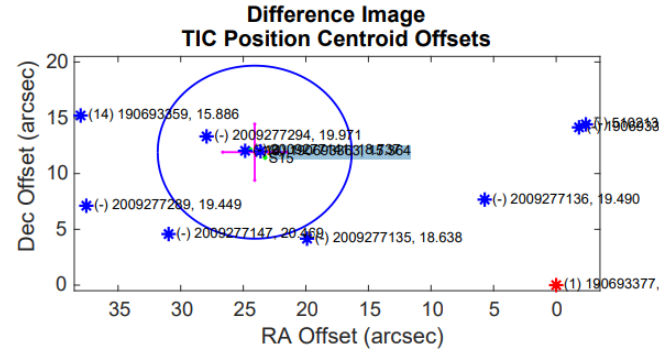

The contaminant is TIC 190693363 (Tmag 15.364, ~26 arcsec away), a known EW type listed in [VSX](https://www.aavso.org/vsx/index.php?view=detail.top&oid=2144228).


#### TESS EB, ASAS-SN, Gaia DR3

- see section [Variability from other catalogs](#meta_other_catalogs)
- fill in: additional notes, if needed.
